<a href="https://colab.research.google.com/github/utmgdsc/TAIL-Trackr/blob/bentoML/catbreed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"devshah2021","key":"7ca39cb5f414dd2979e6b8aa38f5f8dd"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d imbikramsaha/cat-breeds

 91% 190M/208M [00:01<00:00, 148MB/s]
100% 208M/208M [00:01<00:00, 120MB/s]


In [ ]:
!unzip /content/cat-breeds.zip

In [8]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import PIL
import cv2
import requests
from io import BytesIO
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.backend import clear_session

from tensorflow.keras.applications import InceptionResNetV2,InceptionV3
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.xception import Xception

In [9]:
import os
import random
import shutil

# Define the root directory of your dataset
root_dir = "/content/cats-breads"

# Define the output directories for train, test, and val
output_dir = "/content/new"

# Define the percentage splits
train_split = 0.7
test_split = 0.1
val_split = 0.2

# Ensure the output directories exist
os.makedirs(os.path.join(output_dir, "train"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "test"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "val"), exist_ok=True)

# Loop through the cat breed folders
for breed_folder in os.listdir(root_dir):
    if os.path.isdir(os.path.join(root_dir, breed_folder)):
        images = os.listdir(os.path.join(root_dir, breed_folder))
        random.shuffle(images)

        # Calculate the number of images for each split
        total_images = len(images)
        train_count = int(total_images * train_split)
        test_count = int(total_images * test_split)
        val_count = int(total_images * val_split)

        # Split the images and move them to the respective folders
        for i, image in enumerate(images):
            source_path = os.path.join(root_dir, breed_folder, image)
            if i < train_count:
                destination_dir = os.path.join(output_dir, "train", breed_folder)
            elif i < train_count + test_count:
                destination_dir = os.path.join(output_dir, "test", breed_folder)
            else:
                destination_dir = os.path.join(output_dir, "val", breed_folder)

            os.makedirs(destination_dir, exist_ok=True)
            shutil.copy(source_path, os.path.join(destination_dir, image))


In [10]:
TRAIN_DIR = '/content/new/train'
VAL_DIR = '/content/new/val'
TEST_DIR = '/content/new/test'

DIMS = (224,224)
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42

In [11]:
data_gen = ImageDataGenerator(rescale=1/255)

In [12]:
train_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE, directory=TRAIN_DIR, shuffle=True,
                                            target_size=DIMS, class_mode='categorical')

val_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE, directory=VAL_DIR, shuffle=True,
                                            target_size=DIMS, class_mode='categorical')

test_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE, directory=TEST_DIR, shuffle=True,
                                            target_size=DIMS, class_mode='categorical')

Found 1671 images belonging to 12 classes.
Found 479 images belonging to 12 classes.
Found 238 images belonging to 12 classes.


In [13]:
label_mapper = np.asarray(list(train_data.class_indices.keys()))
label_mapper

array(['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair',
       'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue',
       'Siamese', 'Sphynx'], dtype='<U17')

In [14]:
IMG_SHAPE = (224,224,3)
base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet', classes=70)

87910968/87910968 [==============================] - 0s 0us/step


In [19]:
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())
model.add(Dense(12,activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 2048)        0         
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 12)                24588     
                                                                 
Total params: 21827372 (83.26 MB)
Trainable params: 24588 (96.05 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [20]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=2, factor=0.001)
es = EarlyStopping(monitor='val_loss', verbose=2, patience=5, min_delta=0.001)

In [21]:
results = model.fit(train_data, validation_data=val_data,
                epochs=10, verbose=1, callbacks=[reduce_lr,es])

Epoch 1/10
53/53 [==============================] - 277s 5s/step - loss: 2.5869 - accuracy: 0.5990 - val_loss: 1.2213 - val_accuracy: 0.7432 - lr: 0.0100
Epoch 2/10
53/53 [==============================] - 220s 4s/step - loss: 0.7641 - accuracy: 0.8270 - val_loss: 1.1716 - val_accuracy: 0.7453 - lr: 0.0100
Epoch 3/10
53/53 [==============================] - 259s 5s/step - loss: 0.4423 - accuracy: 0.8743 - val_loss: 1.2907 - val_accuracy: 0.7474 - lr: 0.0100
Epoch 4/10
53/53 [==============================] - 252s 5s/step - loss: 0.3115 - accuracy: 0.9031 - val_loss: 1.0442 - val_accuracy: 0.7766 - lr: 0.0100
Epoch 5/10
53/53 [==============================] - 257s 5s/step - loss: 0.2867 - accuracy: 0.9054 - val_loss: 0.9701 - val_accuracy: 0.8017 - lr: 0.0100
Epoch 6/10
53/53 [==============================] - 254s 5s/step - loss: 0.1853 - accuracy: 0.9390 - val_loss: 1.1417 - val_accuracy: 0.7850 - lr: 0.0100
Epoch 7/10
53/53 [==============================] - 254s 5s/step - loss: 0.3

In [22]:
model.evaluate(val_data)

15/15 [==============================] - 50s 3s/step - loss: 1.1576 - accuracy: 0.8372


[1.157595157623291, 0.8371607661247253]

In [23]:
model.save('catmodel.h5')

In [24]:

def predictor(img):
    display(img)
    arr = img_to_array(img)
    arr = arr/255.0
    arr = np.expand_dims(arr,0)
    res = model.predict(arr)
    print(res.shape)
    idx = res.argmax()
    return label_mapper[idx], res[0][idx]

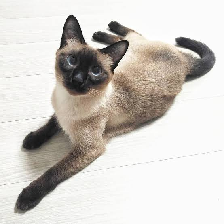

1/1 [==============================] - 2s 2s/step
(1, 12)


('Siamese', 1.0)

In [25]:
url = 'https://encrypted-tbn1.gstatic.com/images?q=tbn:ANd9GcST4vFqkon9beoNKaEGwJsaFJTR7l61rtMhYJgvHEWuc0QT5ajF'
response = requests.get(url)
img = load_img(BytesIO(response.content), target_size=DIMS)

val,prob = predictor(img)
val,prob